# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0


In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load raw data

Here you will implement a simple pytorch dataset that loads the images and labels as describe in the PDF.

In [2]:
# This function load the data
# Input: give the path of the images and labels
# Output: numpy array
        # train_images: shape(7999,128,128,3)
        # train_labels: shape(7999,) array of arraies
        # train_images: shape(2000,128,128,3)
        # train_images: shape(2000,)

def DataLoader(images_path, labels_path):
    # numpy dataload
    images_data = np.load("images.npz",allow_pickle=True)
    labels_data = np.load("labels.npz",allow_pickle=True,encoding="latin1")
    # load the array formed data into the variable
    images_data = images_data["arr_0"]
    labels_data = labels_data["arr_0"]
    # number of data points
    N = images_data.shape[0]
    train_size = int(np.floor(0.8*N))
    # print(train_size)
    test_size = N-train_size
    # print(test_size)
    # split the training data & testing data set.
    train_images = images_data[:train_size,]
    train_labels = labels_data[:train_size,]

    test_images = images_data[train_size:,]
    test_labels = labels_data[train_size:,]
    # assert the data size
    assert train_images.shape[0] == train_size
    assert test_images.shape[0] == test_size
    # switch the dimension position for pytorch loader
    train_X = train_images.transpose((0,3,1,2))
    test_X = test_images.transpose((0,3,1,2))
    return train_X, train_labels, test_X, test_labels

In [3]:
# load the data
train_X, train_labels, test_X, test_labels = DataLoader("images.npz", "labels.npz")
image_H = train_X.shape[2]
train_size = train_X.shape[0]
test_size = test_X.shape[0]
# print(image_H)

In [4]:
print()
print(train_labels)


[array([[  2.,  77.,  49.,  98.,  56.],
       [  2., 108.,  48., 114.,  52.],
       [  2.,  94.,  49., 103.,  55.],
       [  2., 102.,  49., 109.,  54.],
       [  0., 120.,  47., 122.,  51.]])
 array([[  2.,  76.,  45.,  88.,  67.],
       [  2.,   0.,  36.,  61., 105.],
       [  2.,  78.,  45.,  96.,  63.],
       [  2.,  46.,  41.,  84.,  73.],
       [  0., 115.,  50., 117.,  56.],
       [  2.,  93.,  48.,  98.,  59.]])
 array([[  2.,   0.,  47.,  10.,  65.],
       [  2., 124.,  45., 128.,  60.]])
 ...
 array([[  2.,  14.,  49.,  64.,  74.],
       [  2.,  95.,  50., 111.,  61.],
       [  0.,  61.,  47.,  71.,  64.],
       [  0.,   4.,  43.,   9.,  55.],
       [  0.,  79.,  47.,  88.,  63.],
       [  2.,  78.,  49.,  96.,  65.]])
 array([[  2.,  31.,  56.,  42.,  62.],
       [  2.,  41.,  57.,  49.,  62.],
       [  2., 124.,  53., 128.,  61.],
       [  1.,  91.,  47.,  92.,  50.],
       [  2., 114.,  55., 118.,  59.],
       [  0., 109.,  55., 111.,  60.],
       [  

# encode the y label

In [5]:
# This function should change the label data to raw y labels
# Input: label data obtained from DataLoader
# Output: S * S * (5 + C) raw y labels in this case is 8 * 8 * 8
def raw_encoder(label, S, C, image_H):
    # init the zero-matrix of shape: S * S * (5 + C)
    raw_encode = np.zeros((5+C,S,S))
    class_hot_code = np.zeros(C)
    # loop over every item in one picture to form the raw_encode
    for item in label:
        # extract shallow information
        item_class = int(item[0])
        # one-hot code the class
        item_class_hot_code = class_hot_code.copy()
        item_class_hot_code[item_class] = 1
        # corner information of the item
        x1,y1,x2,y2 = item[1:]
        ## here assume the input image is square image
        # compute the pitch size of the grid
        patch = int(image_H/S)
        # compute the center of the item (could be float)
        center_x, center_y = (x1+x2)/2, (y1+y2)/2
        w = x2-x1; h = y2-y1
        # locate which grid the item is in
        grid_x, grid_y = int(center_x//patch), int(center_y//patch)
#         print(grid_x,grid_y)
        center_offset_x, center_offset_y = center_x%patch, center_y%patch
        # record this information into raw_encode
        grid_encoder = [1,center_offset_x,center_offset_y,w,h]
        grid_encoder.extend(item_class_hot_code)
#         print(grid_encoder)
        raw_encode[:,grid_x,grid_y] = grid_encoder
#         print(raw_encode)
#         raw_encode[grid_x,grid_y,:] = [1,center_x,center_y,w,h]
#         raw_encode[grid_x,grid_y,:].extend(item_class_hot_code)
    return raw_encode

In [6]:
# This part encode the training labels into the raw_encoder
S = 8
C = 3
y_label = np.zeros((train_size,5+C,S,S))
for i, label in enumerate(train_labels):
    y_label[i] = raw_encoder(label, S, C, image_H)
print(y_label.shape)

(7999, 8, 8, 8)


# Dataset test

We suggest coming up with a test for your dataset. This is laid out in bullet point 2 under section 6. Testing and confirming that all of this works as expected here will save you headache later.

(3, 128, 128)


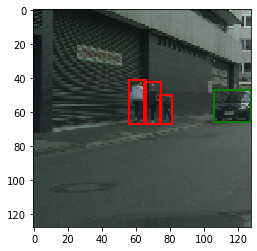

In [7]:
index = 90
print(train_X[0].shape)
fig,ax = plt.subplots(1)
ax.imshow(train_X[index].transpose((1,2,0)))
items = []
for item in train_labels[index]:
    color_index = int(item[0])
    color_list = ['r','b','g']
    x,y = item[1:3]
    w = item[3] - item[1]
    h = item[4] - item[2]
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor=color_list[color_index],facecolor='none',lw=2)

    # Add the patch to the Axes
    ax.add_patch(rect)

In [8]:
print(train_labels[90])
raw_encoder(train_labels[90], S, C, image_H)
print(y_label.shape)
# print(y_label[90])

[[  0.  56.  41.  66.  67.]
 [  2. 106.  47. 128.  66.]
 [  0.  74.  50.  81.  67.]
 [  0.  65.  42.  75.  67.]]
(7999, 8, 8, 8)


decode_image


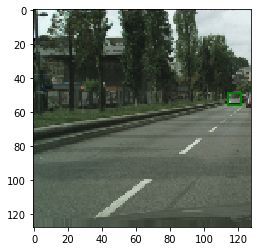


ground_truth_image
decode_image


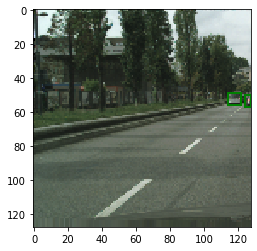

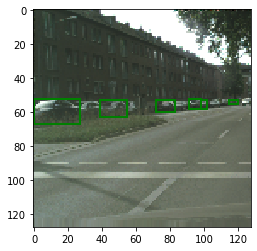


ground_truth_image
decode_image


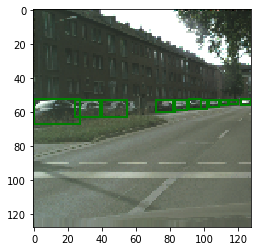

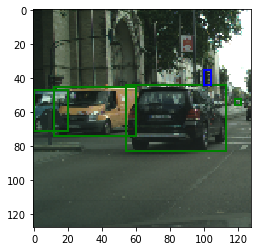


ground_truth_image
decode_image


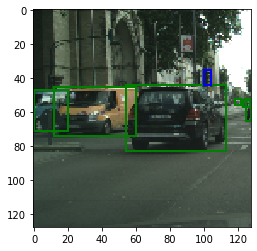

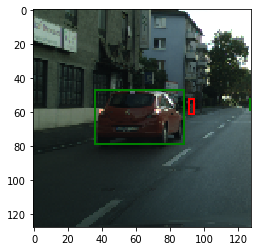


ground_truth_image


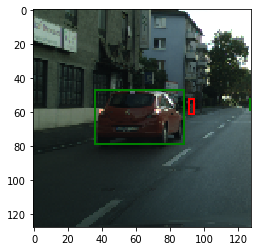

In [9]:
# This function should decode the y label into a image
# Here I assume B=1
# Input: a y label of shape: 8 * 8 * 8
def y_decoder_plot(image,label,S,image_H):
    item_list=[]
    grid_size,_,obj_vect = label.shape
    patch = int(image_H/S)
    for x in range(grid_size):
        for y in range(grid_size):
            obj_vect = label[:,x,y]
            if obj_vect[0]>0:
                center_x,center_y,w,h = x*patch+obj_vect[1],y*patch+obj_vect[2],obj_vect[3],obj_vect[4]
                item_class = np.argmax(obj_vect[5:,])
                item_list.append([item_class,center_x,center_y,w,h])
#     print(item_list)
    plot_given_coor(item_list,image)


def plot_given_coor(item_list,image):
#     print(item_list)
    fig,ax = plt.subplots(1)
    # loop all the items
    ax.imshow(image)
    for item in item_list:
#         print('item',item)
        item_class,center_x,center_y,w,h = item[0],item[1],item[2],item[3],item[4]
#         print('item_class',item_class)
        # The color list we choose from for each object class
        color_list = ['r','b','g']
        # indicate the starting point coor
        start_corner = (center_x-w/2,center_y-h/2)
        # start plot rectangle
        rect = patches.Rectangle(start_corner,w,h,linewidth=1,edgecolor=color_list[item_class],facecolor='none',lw=2)
        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

index_list = [10,50,80,100]
for index in index_list:
    print("decode_image")
    y_decoder_plot(train_X[index].transpose((1,2,0)),y_label[index],S,image_H)
    print()
    print("ground_truth_image")
    fig,ax = plt.subplots(1)
    ax.imshow(train_X[index].transpose((1,2,0)))
    items = []
    for item in train_labels[index]:
        color_index = int(item[0])
        color_list = ['r','b','g']
        x,y = item[1:3]
        w = item[3] - item[1]
        h = item[4] - item[2]
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor=color_list[color_index],facecolor='none',lw=2)

        # Add the patch to the Axes
        ax.add_patch(rect)


In [10]:
print("summary of dataset:\n",
      'train images shape:\n',train_X.shape,'\n',
      'train labels shape:\n',train_labels.shape,'\n',
      'test images shape:\n',test_X.shape,'\n',
      'test labels shape:\n',test_labels.shape)

summary of dataset:
 train images shape:
 (7999, 3, 128, 128) 
 train labels shape:
 (7999,) 
 test images shape:
 (2000, 3, 128, 128) 
 test labels shape:
 (2000,)


# Assumble the data into tensor and put it into dataloader

In [11]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
print(train_X.shape)
# torch.tensor(train_images)
train_dataset = TensorDataset(torch.tensor(((train_X/255)-0.5)/0.5, dtype=torch.double), 
                              torch.tensor(y_label, dtype=torch.double))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
# quick check if the data has been loaded
sample = next(iter(train_loader))
sample_images,sample_labels = sample
print(sample_images.shape)
print(sample_labels.shape)
# print(np.max(((train_X[1]/255)-0.5)/0.5),np.min(((train_X[1]/255)-0.5)/0.5))

(7999, 3, 128, 128)
torch.Size([4, 3, 128, 128])
torch.Size([4, 8, 8, 8])


# Model Definition

In [12]:
class YOLO(torch.nn.Module):
    def __init__(self):
        super(YOLO,self).__init__()
        self.conv1 = nn.Conv2d(3,32,4,stride=2,padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,4,stride=2,padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,4,stride=2,padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128,256,4,stride=2,padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256,512,4,stride=2,padding=1)
        self.conv5_bn = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512,1024,4,stride=2,padding=1)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.trans_conv7 = nn.ConvTranspose2d(1024,256,4,stride=2,padding=1)
        self.trans_conv7_bn = nn.BatchNorm2d(256)
        
        self.trans_conv8 = nn.ConvTranspose2d(256,64,4,stride=2,padding=1)
        self.trans_conv8_bn = nn.BatchNorm2d(64)
        
        self.conv9 = nn.Conv2d(64,8,3,stride=1,padding=1)
    def forward(self, X):
        X = F.relu(self.conv1_bn(self.conv1(X)))
#         print('X size',X.size())
        X = F.relu(self.conv2_bn(self.conv2(X)))
        X = F.relu(self.conv3_bn(self.conv3(X)))
        X = F.relu(self.conv4_bn(self.conv4(X)))
        X = F.relu(self.conv5_bn(self.conv5(X)))
        X = F.relu(self.conv6_bn(self.conv6(X)))
        X = F.relu(self.trans_conv7_bn(self.trans_conv7(X)))
#         print('X size',X.size())
        X = F.relu(self.trans_conv8_bn(self.trans_conv8(X)))
        X = self.conv9(X)
        return X

In [13]:
## This function should calculate the IoU when the pred and gt are in the same grid. 
## This could be regard as a normalization
def IoU_fix_grid(pred_x,pred_y,pred_w,pred_h,gt_x,gt_y,gt_w,gt_h):
    # compute the range of the pred bounding box
    pred_x_min = pred_x-pred_w/2
    pred_x_max = pred_x+pred_w/2
    pred_y_min = pred_y-pred_h/2
    pred_y_max = pred_y+pred_h/2
    # compute the pred area
    pred_area = pred_w*pred_h
    
    # compute the range of the pred bounding box
    gt_x_min = gt_x - gt_w/2
    gt_x_max = gt_x + gt_w/2
    gt_y_min = gt_y - gt_h/2
    gt_y_max = gt_y + gt_h/2 
    # compute the pred area
    gt_area = gt_w*gt_h
    # compute the intersect w & h
    intersect_pred_gt_w = max(0,min(pred_x_max,gt_x_max)-max(pred_x_min,gt_x_min))
    intersect_pred_gt_h = max(0,min(pred_y_max,gt_y_max)-max(pred_y_min,gt_y_min))
    # compute intersect area
    intersect_area = intersect_pred_gt_w*intersect_pred_gt_h
    # compute union area
    union_area = pred_area + gt_area - intersect_area
    IoU_fix_grid = intersect_area/union_area
    return IoU_fix_grid

# This function should calculate the IoU w.r.t. the whole pict
def IoU(grid_x1,grid_y1,x1,y1,w1,h1,grid_x2,grid_y2,x2,y2,w2,h2,grid_patch):
    # compute the range of the x1 bounding box
    pred_x_min = grid_x1*grid_patch + x1-w1/2
    pred_x_max = grid_x1*grid_patch + x1+w1/2
    pred_y_min = grid_y1*grid_patch + y1-h1/2
    pred_y_max = grid_y1*grid_patch + y1+h1/2
    # compute the x1 area
    pred_area = w1*h1
    
    # compute the range of the x2 bounding box
    gt_x_min = grid_x2*grid_patch + x2 - w2/2
    gt_x_max = grid_x2*grid_patch + x2 + w2/2
    gt_y_min = grid_y2*grid_patch + y2 - h2/2
    gt_y_max = grid_y2*grid_patch + y2 + h2/2 
    # compute the x2 area
    gt_area = w2*h2
    
    # compute the intersect w & h
    intersect_pred_gt_w = max(0,min(pred_x_max,gt_x_max)-max(pred_x_min,gt_x_min))
    intersect_pred_gt_h = max(0,min(pred_y_max,gt_y_max)-max(pred_y_min,gt_y_min))
    # compute intersect area
    intersect_area = intersect_pred_gt_w*intersect_pred_gt_h
    # compute union area
    union_area = pred_area + gt_area - intersect_area
    IoU = intersect_area/union_area
    return IoU


def YOLO_loss(pred,target,lambda_coord,lambda_noobj,C):
    batch_size = pred.size()[0]
    S = pred.size()[2]
    channel_len = pred.size()[1]
    loss = 0
    for i in range(batch_size):
        for x in range(S):
            for y in range(S):
                pred_objness,pred_x,pred_y,pred_w,pred_h,pred_pr_cl,pred_pr_c2,pred_pr_c3 = [pred[i,ind,x,y] for ind in range(channel_len)]
                gt_objness,gt_x,gt_y,gt_w,gt_h,gt_pr_cl,gt_pr_c2,gt_pr_c3 = [target[i,ind,x,y] for ind in range(channel_len)]
                if gt_objness == 1:
                    IoU_xy = IoU_fix_grid(pred_x,pred_y,pred_w,pred_h,gt_x,gt_y,gt_w,gt_h)
#                     print('IoU',IoU_xy)
                    loss += lambda_coord*((gt_x - pred_x)**2 + (gt_y - pred_y)**2) + lambda_coord*((torch.sqrt(max(torch.tensor(0, dtype=torch.double),pred_w)) - torch.sqrt(max(torch.tensor(0, dtype=torch.double),gt_w)))**2 + (torch.sqrt(max(torch.tensor(0, dtype=torch.double),pred_h)) - torch.sqrt(max(torch.tensor(0, dtype=torch.double),gt_h)))**2) + ((pred_objness-1)*IoU_xy)**2+ torch.sum((pred[i,5:,x,y] - target[i,5:,x,y])**2)
#                     print("part1 of loss",lambda_coord*((gt_x - pred_x)**2 + (gt_y - pred_y)**2))
# #                     print('part2 of loss',lambda_coord*((torch.sqrt(pred_w) - torch.sqrt(gt_w))**2 + (torch.sqrt(pred_h) - torch.sqrt(gt_h))**2))
#                     print('part2 of loss',lambda_coord*((torch.sqrt(max(torch.tensor(0, dtype=torch.double),pred_w)) - torch.sqrt(max(torch.tensor(0, dtype=torch.double),gt_w)))**2 + (torch.sqrt(max(torch.tensor(0, dtype=torch.double),pred_h)) - torch.sqrt(max(torch.tensor(0, dtype=torch.double),gt_h)))**2) + ((pred_objness-1)*IoU_xy)**2)
# #                     print('part4 of loss',pred_h)
#                     print('part3 of loss', ((pred_objness-1)*IoU_xy)**2+ torch.sum((pred[i,5:,x,y] - target[i,5:,x,y])**2))
#                     print('loss',loss)
                elif gt_objness == 0:
                    loss += lambda_noobj*(pred_objness - 0)**2
    return loss

# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

In [14]:
# load the trained network, if the network is already trained
net = YOLO()
net = net.double()
optimizer = optim.Adam(net.parameters(),lr=0.001)

checkpoint = torch.load("./epoch/train_epoch29")
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

In [21]:
net = YOLO()
net = net.double()
# manual objective function
lambda_coord = 5
lambda_noobj = 0.5
traning_loss = []
runing_loss=0
record_step = 100
optimizer = optim.Adam(net.parameters(),lr=0.001)
# optimizer = optim.SGD(net.parameters(),lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs,labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forwords
        outputs = net(inputs)
        # compute the loss
        loss = YOLO_loss(outputs,labels,lambda_coord,lambda_noobj,C)
        loss.backward()
        optimizer.step()
#         print(loss)

        runing_loss += loss
        if i % record_step == record_step-1:
            print(i+1,' th iter in ',epoch+1,'epoch', runing_loss/record_step)
            traning_loss.append(runing_loss)
            runing_loss=0


100  th iter in  1 epoch tensor(4462.1301, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  1 epoch tensor(3290.3815, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  1 epoch tensor(3164.2229, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  1 epoch tensor(3267.4619, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  1 epoch tensor(3105.1188, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  1 epoch tensor(3089.0974, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  1 epoch tensor(3014.7741, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  1 epoch tensor(3029.5573, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  1 epoch tensor(2896.9504, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  1 epoch tensor(2808.8651, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  1 epoch tensor(2861.2273, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  1 epoch tens

1400  th iter in  5 epoch tensor(2215.3156, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  5 epoch tensor(2243.4522, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  5 epoch tensor(2129.9017, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  5 epoch tensor(2218.8393, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  5 epoch tensor(2257.0570, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  5 epoch tensor(2313.7405, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  5 epoch tensor(2214.1826, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  6 epoch tensor(1966.2174, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  6 epoch tensor(2038.0470, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  6 epoch tensor(2128.5869, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  6 epoch tensor(1954.0834, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  6 epoch 

700  th iter in  10 epoch tensor(716.9361, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  10 epoch tensor(768.8292, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  10 epoch tensor(762.9739, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  10 epoch tensor(740.9124, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  10 epoch tensor(738.5797, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  10 epoch tensor(723.7351, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  10 epoch tensor(779.1696, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  10 epoch tensor(823.9426, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  10 epoch tensor(777.1879, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  10 epoch tensor(802.3286, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  10 epoch tensor(842.2978, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  10 epo

2000  th iter in  14 epoch tensor(387.7290, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  15 epoch tensor(370.2468, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  15 epoch tensor(318.7929, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  15 epoch tensor(314.3165, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  15 epoch tensor(331.3458, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  15 epoch tensor(330.4036, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  15 epoch tensor(346.4447, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  15 epoch tensor(341.8314, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  15 epoch tensor(332.8096, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  15 epoch tensor(316.5379, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  15 epoch tensor(324.2182, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  15 epoch ten

1300  th iter in  19 epoch tensor(222.0235, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  19 epoch tensor(246.8100, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  19 epoch tensor(247.5537, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  19 epoch tensor(246.1850, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  19 epoch tensor(248.7834, dtype=torch.float64, grad_fn=<DivBackward0>)
1800  th iter in  19 epoch tensor(238.5605, dtype=torch.float64, grad_fn=<DivBackward0>)
1900  th iter in  19 epoch tensor(226.1912, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  19 epoch tensor(232.4904, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  20 epoch tensor(221.0212, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  20 epoch tensor(214.7278, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  20 epoch tensor(201.5335, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  20 epoc

600  th iter in  24 epoch tensor(164.7472, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  24 epoch tensor(155.2564, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  24 epoch tensor(164.3364, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  24 epoch tensor(154.6872, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  24 epoch tensor(160.1840, dtype=torch.float64, grad_fn=<DivBackward0>)
1100  th iter in  24 epoch tensor(175.0339, dtype=torch.float64, grad_fn=<DivBackward0>)
1200  th iter in  24 epoch tensor(160.3717, dtype=torch.float64, grad_fn=<DivBackward0>)
1300  th iter in  24 epoch tensor(160.8185, dtype=torch.float64, grad_fn=<DivBackward0>)
1400  th iter in  24 epoch tensor(175.2532, dtype=torch.float64, grad_fn=<DivBackward0>)
1500  th iter in  24 epoch tensor(173.5890, dtype=torch.float64, grad_fn=<DivBackward0>)
1600  th iter in  24 epoch tensor(169.5482, dtype=torch.float64, grad_fn=<DivBackward0>)
1700  th iter in  24 epoc

1900  th iter in  28 epoch tensor(128.1694, dtype=torch.float64, grad_fn=<DivBackward0>)
2000  th iter in  28 epoch tensor(131.7510, dtype=torch.float64, grad_fn=<DivBackward0>)
100  th iter in  29 epoch tensor(119.6634, dtype=torch.float64, grad_fn=<DivBackward0>)
200  th iter in  29 epoch tensor(118.2763, dtype=torch.float64, grad_fn=<DivBackward0>)
300  th iter in  29 epoch tensor(126.3385, dtype=torch.float64, grad_fn=<DivBackward0>)
400  th iter in  29 epoch tensor(123.5237, dtype=torch.float64, grad_fn=<DivBackward0>)
500  th iter in  29 epoch tensor(127.2913, dtype=torch.float64, grad_fn=<DivBackward0>)
600  th iter in  29 epoch tensor(125.3159, dtype=torch.float64, grad_fn=<DivBackward0>)
700  th iter in  29 epoch tensor(128.8193, dtype=torch.float64, grad_fn=<DivBackward0>)
800  th iter in  29 epoch tensor(121.5367, dtype=torch.float64, grad_fn=<DivBackward0>)
900  th iter in  29 epoch tensor(125.5217, dtype=torch.float64, grad_fn=<DivBackward0>)
1000  th iter in  29 epoch ten

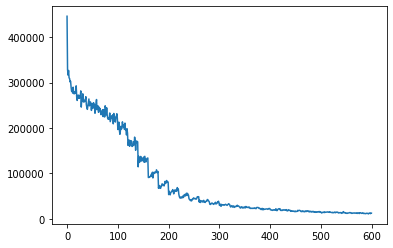

In [22]:
plt.plot(traning_loss)

In [25]:
torch.save({
            'epoch': epoch+1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, "./epoch/train_epoch"+str(epoch))

In [24]:
print(epoch)

29


# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

(8, 8, 8)


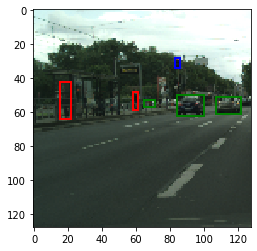

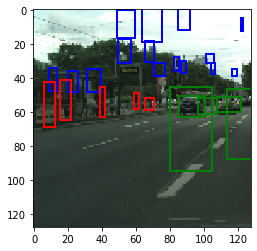

In [15]:
def y_decoder_plot(image,label,S,image_H):
    item_list=[]
    grid_size,_,obj_vect = label.shape
    patch = int(image_H/S)
#     print(label[0,:,:])
    for x in range(grid_size):
        for y in range(grid_size):
            obj_vect = label[:,x,y]
            if obj_vect[0]>0:
                center_x,center_y,w,h = x*patch+obj_vect[1],y*patch+obj_vect[2],obj_vect[3],obj_vect[4]
                item_class = np.argmax(obj_vect[5:,])
                item_list.append([item_class,center_x,center_y,w,h])
#     print(item_list)
    plot_given_coor(item_list,image)

    
net = net.eval()
index = 1000
outputs = net(torch.tensor((train_X[index]/255-0.5)/0.5, dtype=torch.double).unsqueeze(0))

print(outputs.detach().numpy().squeeze(0).shape)

y_decoder_plot(train_X[index].transpose((1,2,0)),y_label[index],S,image_H)

y_decoder_plot(train_X[index].transpose((1,2,0)),outputs.detach().numpy().squeeze(0),S,image_H)

In [16]:
# test_size = test_X.shape[0]
test_y_label = np.zeros((test_size,5+C,S,S))
for i, label in enumerate(test_labels):
    test_y_label[i] = raw_encoder(label, S, C, image_H)
print(test_y_label.shape)

(2000, 8, 8, 8)


(8, 8, 8)


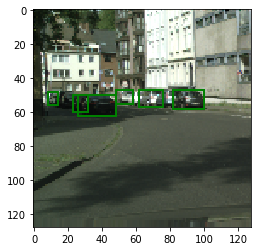

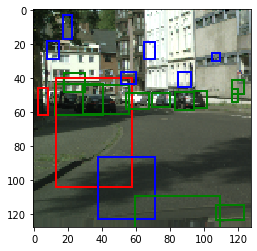

In [17]:
net = net.eval()
index = 10
outputs = net(torch.tensor((test_X[index]/255-0.5)/0.5, dtype=torch.double).unsqueeze(0))

print(outputs.detach().numpy().squeeze(0).shape)

y_decoder_plot(test_X[index].transpose((1,2,0)),test_y_label[index],S,image_H)

y_decoder_plot(test_X[index].transpose((1,2,0)),outputs.detach().numpy().squeeze(0),S,image_H)

# non-Maximum suppression

In [18]:
# This function should calculate the IoU w.r.t. the whole pict
def IoU(grid_x1,grid_y1,x1,y1,w1,h1,grid_x2,grid_y2,x2,y2,w2,h2,grid_patch):
    # compute the range of the x1 bounding box
    pred_x_min = grid_x1*grid_patch + x1-w1/2
    pred_x_max = grid_x1*grid_patch + x1+w1/2
    pred_y_min = grid_y1*grid_patch + y1-h1/2
    pred_y_max = grid_y1*grid_patch + y1+h1/2
    # compute the x1 area
    pred_area = w1*h1
    
    # compute the range of the x2 bounding box
    gt_x_min = grid_x2*grid_patch + x2 - w2/2
    gt_x_max = grid_x2*grid_patch + x2 + w2/2
    gt_y_min = grid_y2*grid_patch + y2 - h2/2
    gt_y_max = grid_y2*grid_patch + y2 + h2/2 
    # compute the x2 area
    gt_area = w2*h2
    
    # compute the intersect w & h
    intersect_pred_gt_w = max(0,min(pred_x_max,gt_x_max)-max(pred_x_min,gt_x_min))
    intersect_pred_gt_h = max(0,min(pred_y_max,gt_y_max)-max(pred_y_min,gt_y_min))
    # compute intersect area
    intersect_area = intersect_pred_gt_w*intersect_pred_gt_h
    # compute union area
    union_area = pred_area + gt_area - intersect_area
    IoU = intersect_area/union_area
    return IoU
print(image_H/S)
print(IoU(0,0,8,8,32,32,1,0,8,8,32,32,image_H/S))

16.0
0.3333333333333333


In [19]:
# This function to apply NMS to the output y_label
# Input: (C+5) * S * S
# single y_label after NMS
def NMS(pred,S,first_threshold=0.2,NMS_threshold=0.2):
    ## construct two pred copy to record two step NMS
    pred_threshold = pred.clone()
    pred_NMS = pred.clone()
    # sort the grid according to the first channel which is the objectness
    vect_first_channel = pred[0,:,:].view(-1,1) # row-based vecterize
    # torch sort
    sorted, indices = torch.sort(vect_first_channel,0,descending=True)
    # extract out the index coor
    ind_coor = torch.stack([indices//S,indices%S],1)
#     print('size',sorted.size())
#     print('type',sorted.type())
#     print(sorted)
    sorted = torch.where(sorted > first_threshold,sorted,torch.zeros(sorted.size(),dtype=torch.double))
#     print(sorted)
#     ind_coor.detach().numpy()
    previous_list = []
    for i in range(S*S):
        if sorted[i]==0:
            cur_order_coor_tensor = ind_coor[i].squeeze()
            pred_threshold[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
            pred_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
        else:
#             print('current is:', i)
            ## compute the info of current position
            cur_order_coor_tensor = ind_coor[i].squeeze()
#             print('current is:', cur_order_coor_tensor[0],cur_order_coor_tensor[1])
            cur_grid_info = pred[:,cur_order_coor_tensor[0],cur_order_coor_tensor[1]].detach().numpy()
            # find out the class of pred in current grid
            cur_class = np.argmax(cur_grid_info[5:,])
#             print('cur_class',cur_class)
            # location info of current grid
            cur_x,cur_y,cur_w,cur_h = cur_grid_info[1:5,]
#             print('previous is:', i-1)
            
            for element in previous_list:
                # extract out the all previous information
                [pre_class,pre_x,pre_y,pre_w,pre_h,pre_order_coor_tensor] = element
#                 print('current is:', cur_order_coor_tensor[0],cur_order_coor_tensor[1])
#                 print('previos is:', pre_order_coor_tensor[0],pre_order_coor_tensor[1])
                # compute the IoU between current and previous 
                IoU_cur_pre = IoU(cur_order_coor_tensor[0],cur_order_coor_tensor[1],cur_x,cur_y,cur_w,cur_h,
                  pre_order_coor_tensor[0],pre_order_coor_tensor[1],pre_x,pre_y,pre_w,pre_h,
                  int(image_H/S))
#                 print('position_current',cur_x,cur_y,cur_w,cur_h,'position_previous',pre_x,pre_y,pre_w,pre_h)
#                 print('IoU_cur_pre',IoU_cur_pre)
                # if condition satisfied suppress the current box 
                if pre_class == cur_class and IoU_cur_pre >= NMS_threshold:
                    pred_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] = 0
                    break
            # if current box survive, record it.
            if pred_NMS[0,cur_order_coor_tensor[0],cur_order_coor_tensor[1]] != 0:
                previous_list.append([cur_class,cur_x,cur_y,cur_w,cur_h,cur_order_coor_tensor])
#             print()
#             print()
#     print(pred_threshold[0,:,:])
    return pred_threshold, pred_NMS

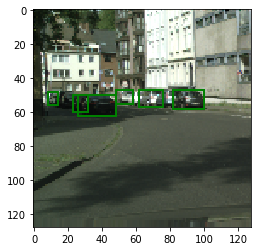

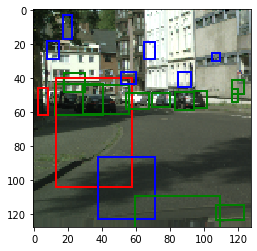

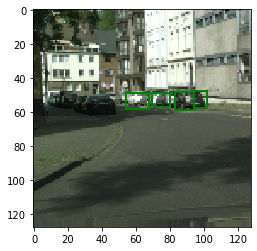

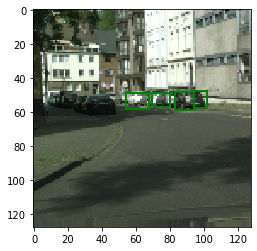

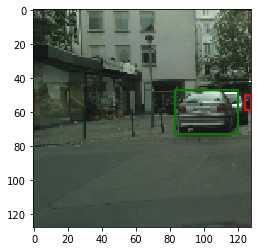

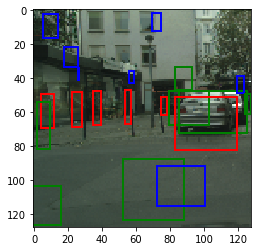

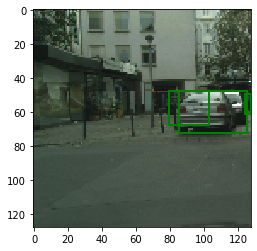

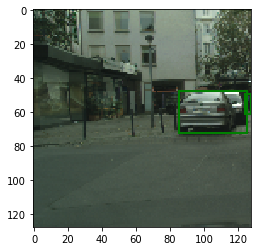

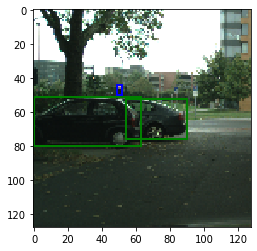

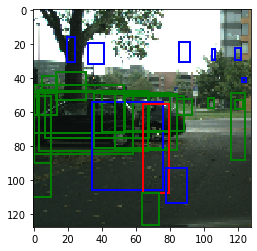

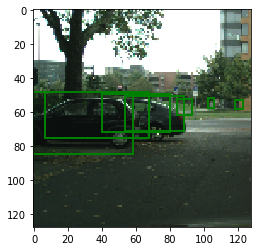

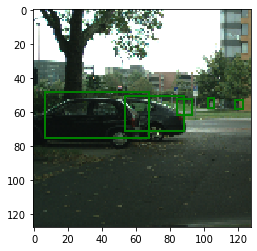

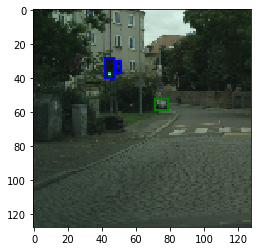

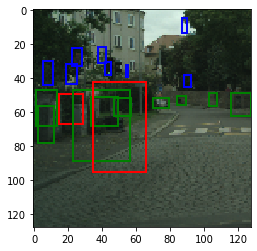

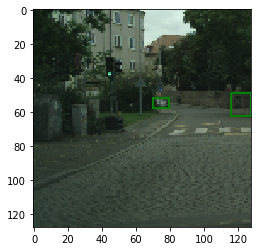

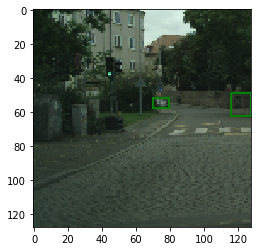

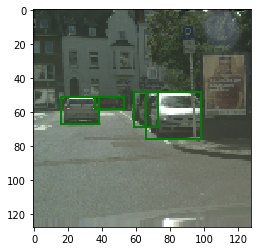

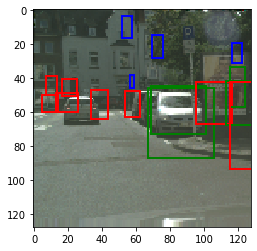

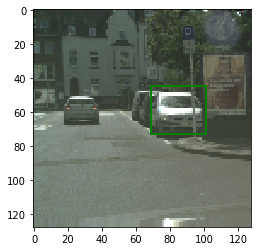

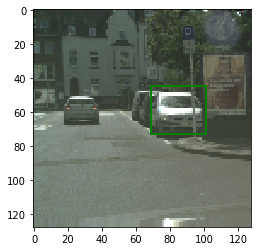

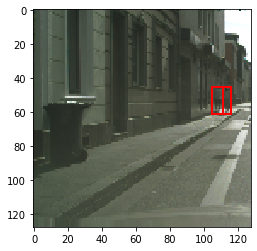

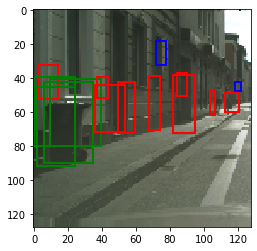

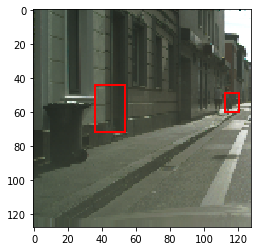

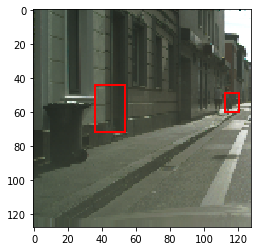

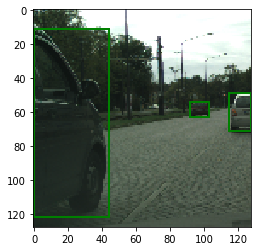

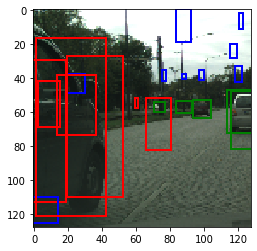

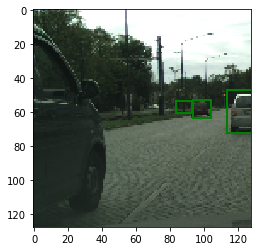

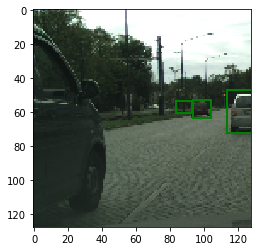

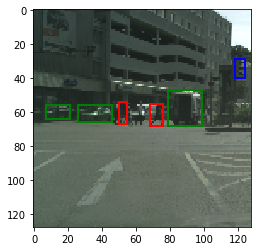

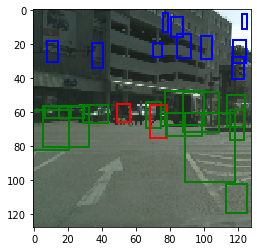

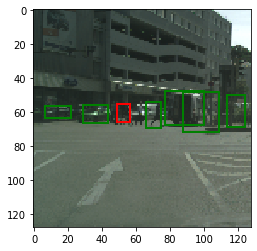

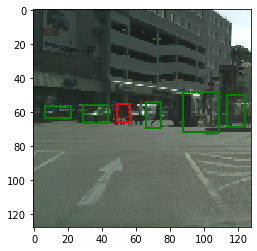

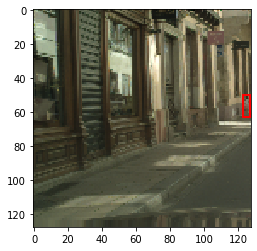

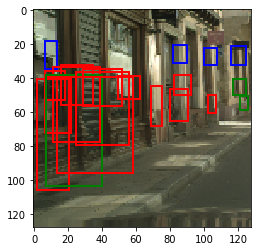

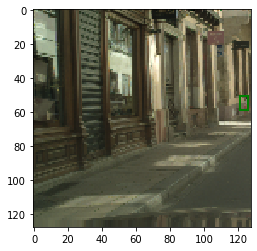

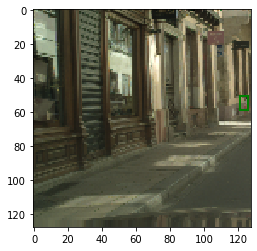

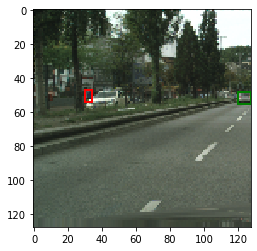

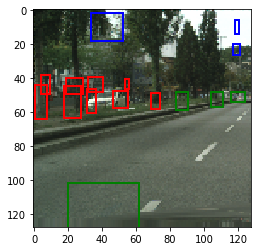

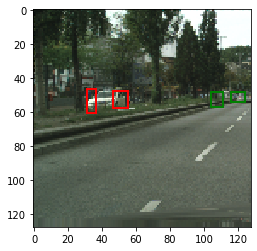

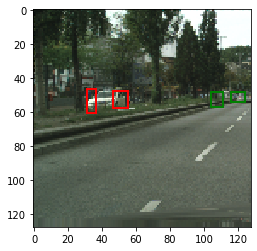

In [52]:
net = net.eval()
index = [10,20,30,40,50,60,70,80,90,100]
first_threshold = 0.3
NMS_threshold = 0.2
for images_ind in index:
    outputs = net(torch.tensor((test_X[images_ind]/255-0.5)/0.5, dtype=torch.double).unsqueeze(0))
    # outputs_NMS = NMS(outputs.squeeze(0),S,0.2)

    #     print(outputs.detach().numpy().squeeze(0).shape)
    #     print(outputs_NMS.shape)
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),test_y_label[images_ind],S,image_H)

    #     y_decoder_plot(test_X[images_ind].transpose((1,2,0)),outputs.detach().numpy().squeeze(0),S,image_H)
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),outputs.detach().numpy().squeeze(0),S,image_H)
    pred_threshold, pred_NMS = NMS(outputs.squeeze(0),S,first_threshold,NMS_threshold)
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),pred_threshold.detach().numpy(),S,image_H)
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),pred_NMS.detach().numpy(),S,image_H)
    print();print();print();print();print();print();print();print();print();print();print();print()

# visualize each channel in the output tensor

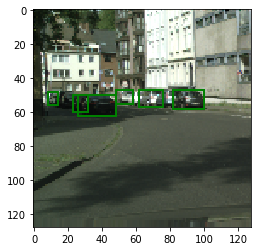

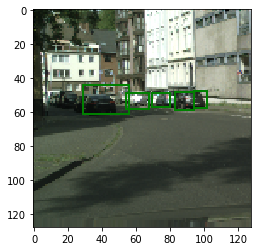

Objectness


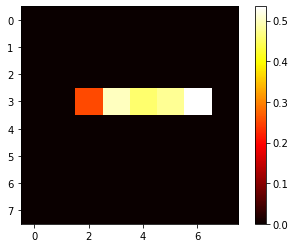

center_x


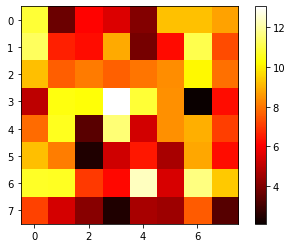

center_y


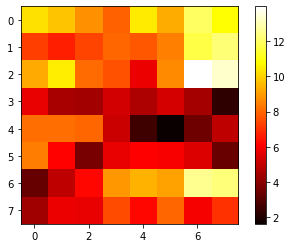

w


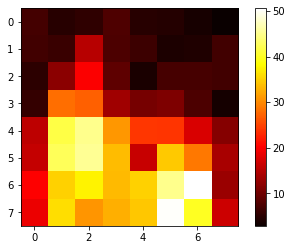

h


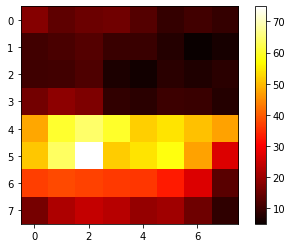

class1


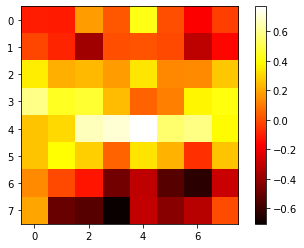

class2


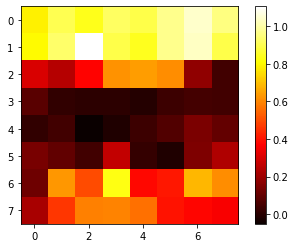

class3


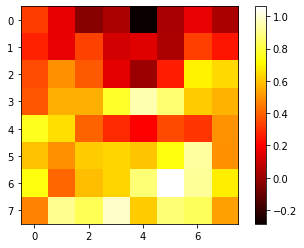

In [21]:
# This part plot the energy map of predictions after NMS
import matplotlib.cm as cm

index = [10]
first_threshold = 0.2
NMS_threshold = 0.2
for images_ind in index:
    # plot the ground truth boxes
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),test_y_label[images_ind],S,image_H)
    # plot the prediction boxes after NMS
    outputs = net(torch.tensor((test_X[images_ind]/255-0.5)/0.5, dtype=torch.double).unsqueeze(0))
    pred_threshold, pred_NMS = NMS(outputs.squeeze(0),S,first_threshold,NMS_threshold)
    y_decoder_plot(test_X[images_ind].transpose((1,2,0)),pred_NMS.detach().numpy(),S,image_H)
#     print(pred_NMS.size())
#     print(pred_NMS[0,:,:].shape)
    # plot the energy map in each channel
    channel_name = ['Objectness','center_x','center_y','w','h','class1','class2','class3']
    for channel in range(5+C):
        print(channel_name[channel])
        plt.imshow(pred_NMS[channel,:,:].detach().numpy().transpose((1,0)),cmap=cm.hot)
        plt.colorbar()
        plt.show()

# data set is unbalanced

In [50]:
# One question: if the training data is balanced
# print(y_label[:,5:,:,:])
# print(train_labels.shape)
# print(train_labels[0])
def data_balance(label_set):
    class_num_dict = {}
    for pict in range(label_set.shape[0]):
        for item in label_set[pict]:
            try:
                class_num_dict[item[0]] += 1
            except:
                class_num_dict[item[0]] = 1
    return class_num_dict

train_data_balance_dict = data_balance(train_labels)
test_data_balance_dict = data_balance(test_labels)

whole_data_balance = {}
whole_data_balance[0] = train_data_balance_dict[0]+test_data_balance_dict[0]
whole_data_balance[1] = train_data_balance_dict[1]+test_data_balance_dict[1]
whole_data_balance[2] = train_data_balance_dict[2]+test_data_balance_dict[2]
print("For the training data set, we have the following distribution:\n",train_data_balance_dict)
print("For the testing data set, we have the following distribution:\n",test_data_balance_dict)
print("For the whole data set, we have the following distribution:\n",whole_data_balance)

For the training data set, we have the following distribution:
 {2.0: 29657, 0.0: 12817, 1.0: 2281}
For the testing data set, we have the following distribution:
 {0.0: 3203, 2.0: 7425, 1.0: 594}
For the whole data set, we have the following distribution:
 {0: 16020, 1: 2875, 2: 37082}


# mAP